# Model training

The input data is prepared by joining the calculated windfield with damaged values.
Subsampling is done by dropping those rows where the windspeed is 0, the the data stratification is done on damaged values.
The XGBoost Reduced Over fitting model, was trained on this prepared input data with gridcells.
The RMSE calculated in total and per each bin.

In [ ]:
%load_ext jupyter_black

In [ ]:
from collections import defaultdict
import statistics

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import colorama
from colorama import Fore

from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
# Read csv file and import to df
df = get_training_dataset()
# df

array([[<AxesSubplot:title={'center':'percent_buildings_damaged'}>]],
      dtype=object)

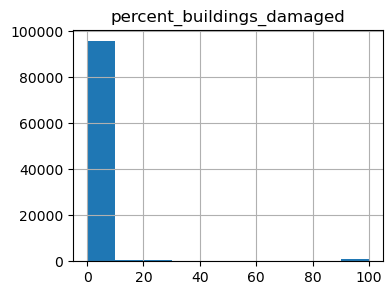

In [ ]:
# Show histogram of damage
df.hist(column="percent_buildings_damaged", figsize=(4, 3))

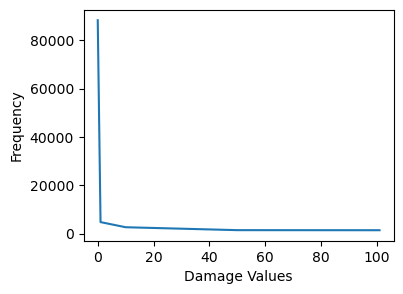

In [ ]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [ ]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["percent_buildings_damaged"].value_counts(bins=binsP2)

In [ ]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,total_buildings,rainfall_max_6h,rainfall_max_24h,percent_buildings_damaged
48,DURIAN,13.077471,262.598363,35.0,0.716667,0.424479,0.0
49,DURIAN,12.511864,273.639330,179.0,0.568750,0.336979,0.0
50,DURIAN,11.977511,284.680297,44.0,0.589583,0.290625,0.0
51,DURIAN,11.471921,295.721263,14.0,0.620833,0.301042,0.0
59,DURIAN,14.394863,239.279840,5.0,2.464583,1.222917,0.0


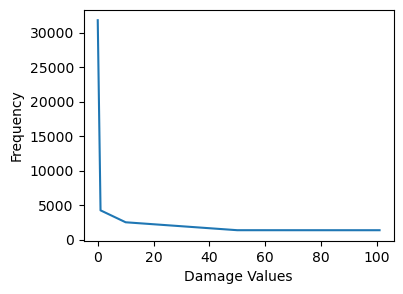

In [ ]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_buildings_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [ ]:
print(samples_per_bin2)
print(binsP2)

In [ ]:
# Check the bins' intervalls
df["percent_buildings_damaged"].value_counts(bins=binsP2)

In [ ]:
bin_index2 = np.digitize(df["percent_buildings_damaged"], bins=binsP2)

In [ ]:
y_input_strat = bin_index2

In [13]:
# Defin two lists to save total RMSE of test and train data

test_RMSE = defaultdict(list)
train_RMSE = defaultdict(list)

In [ ]:
features = [
    "wind_speed",
    "track_distance",
    "total_buildings",
    "rainfall_max_6h",
    "rainfall_max_24h",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_buildings_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_buildings', 'rainfall_max_6h',
       'rainfall_max_24h'],
      dtype='object')

In [ ]:
# Run XGBoost Reduced Overfitting in for loop to estimate RMSE per bins

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, df["percent_buildings_damaged"], stratify=y_input_strat, test_size=0.2
    )

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=1,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_test, y_test)]
    xgb_model = xgb.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        # sample_weight=pow(y_train, 2),
    )

    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())

    X2_test = sm.add_constant(X_test)

    y_pred_train_LREG = est2.predict(X2)
    mse_train_idx_LREG = mean_squared_error(y_train, y_pred_train_LREG)
    rmse_train_LREG = np.sqrt(mse_train_idx_LREG)

    ypred_LREG = est2.predict(X2_test)
    mse_idx_LREG = mean_squared_error(y_test, ypred_LREG)
    rmse_LREG = np.sqrt(mse_idx_LREG)

    print("----- Training ------")
    print(f"LREG Root mean squared error: {rmse_train_LREG:.2f}")
    print("----- Test ------")
    print(f"LREG Root mean squared error: {rmse_LREG:.2f}")

    # Calculate RMSE in total

    y_pred_train = xgb.predict(X_train)
    mse_train_idx = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train_idx)

    y_pred = xgb.predict(X_test)
    mse_idx = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse_idx)

    print("----- Training ------")
    print(f"Root mean squared error: {rmse_train:.2f}")

    print("----- Test ------")
    print(f"Root mean squared error: {rmse:.2f}")

    test_RMSE["all"].append(rmse)
    train_RMSE["all"].append(rmse_train)

    # Calculate RMSE per bins

    bin_index_test = np.digitize(y_test, bins=binsP2)
    bin_index_train = np.digitize(y_train, bins=binsP2)

    # Estimation of RMSE for train data
    y_pred_train = xgb.predict(X_train)
    for bin_num in range(1, 6):

        mse_train_idx = mean_squared_error(
            y_train[bin_index_train == bin_num],
            y_pred_train[bin_index_train == bin_num],
        )
        rmse_train = np.sqrt(mse_train_idx)

        # Estimation of RMSE for test data
        y_pred = xgb.predict(X_test)

        mse_idx = mean_squared_error(
            y_test[bin_index_test == bin_num],
            y_pred[bin_index_test == bin_num],
        )
        rmse = np.sqrt(mse_idx)

        train_RMSE[bin_num].append(rmse_train)
        test_RMSE[bin_num].append(rmse)

[16:58:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                                OLS Regression Results                               
Dep. Variable:     percent_buildings_damaged   R-squared:                       0.228
Model:                                   OLS   Adj. R-squared:                  0.228
Method:                        Least Squares   F-statistic:                     1945.
Date:                       Thu, 19 Jan 2023   Prob (F-statistic):               0.00
Time:                               16:58:00   Log-Likelihood:            -1.3575e+05
No. Observations:                      32995   

In [ ]:
# Define a function to plot RMSEs
def rmse_bin_plot(te_rmse, tr_rmse, min_rg, max_rg, step):

    m_test_rmse = statistics.mean(te_rmse)
    plt.figure(figsize=(4, 3))
    plt.axvline(m_test_rmse, color="red", linestyle="dashed")
    plt.hist(
        te_rmse,
        bins=np.arange(min_rg, max_rg, step),
        edgecolor="k",
        histtype="bar",
        density=True,
    )
    sd_test_rmse = statistics.stdev(te_rmse)

    m_train_rmse = statistics.mean(tr_rmse)
    plt.axvline(m_train_rmse, color="b", linestyle="dashed")
    plt.hist(
        tr_rmse,
        bins=np.arange(min_rg, max_rg, step),
        color="orange",
        edgecolor="k",
        histtype="bar",
        density=True,
        alpha=0.7,
    )
    sd_train_rmse = statistics.stdev(tr_rmse)

    print(Fore.RED)
    print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
    print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

    print(f"mean_RMSE_test: {m_test_rmse:.2f}")
    print(f"mean_RMSE_train: {m_train_rmse:.2f}")

    # create legend
    labels = ["Mean_test", "Mean_train", "test", "train"]
    plt.legend(labels)

    plt.xlabel("The RMSE error")
    plt.ylabel("Frequency")
    plt.title("histogram of the RMSE distribution")
    plt.show()

## Plot RMSE in total

RMSE in total 


stdev_RMSE_test: 0.17
stdev_RMSE_train: 0.04
mean_RMSE_test: 13.35
mean_RMSE_train: 12.36


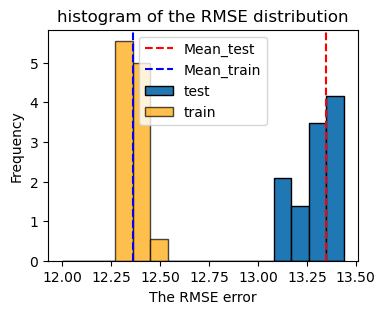

In [17]:
print("RMSE in total", "\n")
rmse_bin_plot(test_RMSE["all"], train_RMSE["all"], 12.0, 13.5, 0.09)

## Plot RMSE per bin

RMSE per bin 1


stdev_RMSE_test: 0.19
stdev_RMSE_train: 0.05
mean_RMSE_test: 4.19
mean_RMSE_train: 3.88


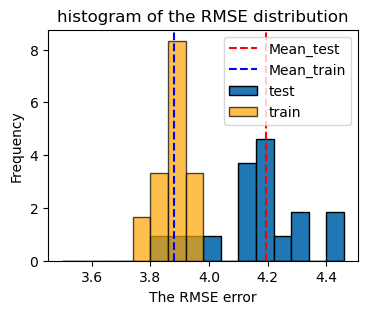

RMSE per bin 2


stdev_RMSE_test: 0.59
stdev_RMSE_train: 0.15
mean_RMSE_test: 8.86
mean_RMSE_train: 8.13


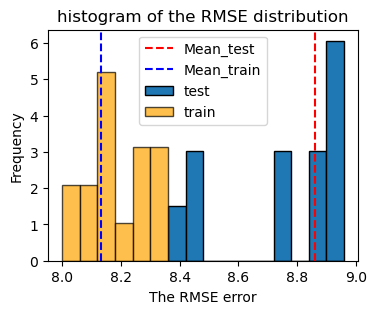

RMSE per bin 3


stdev_RMSE_test: 0.75
stdev_RMSE_train: 0.17
mean_RMSE_test: 13.52
mean_RMSE_train: 12.21


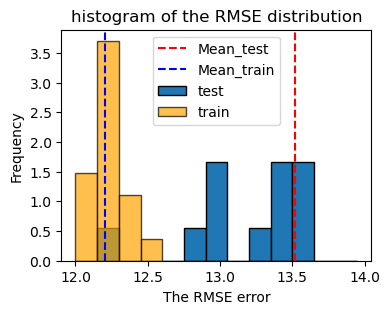

RMSE per bin 4


stdev_RMSE_test: 0.87
stdev_RMSE_train: 0.23
mean_RMSE_test: 19.75
mean_RMSE_train: 18.21


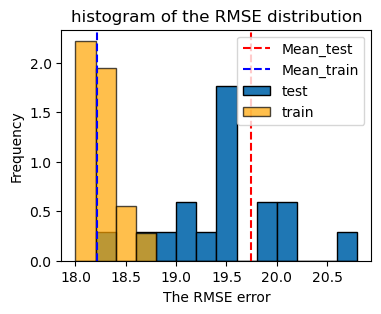

RMSE per bin 5


stdev_RMSE_test: 1.07
stdev_RMSE_train: 0.26
mean_RMSE_test: 63.65
mean_RMSE_train: 59.19


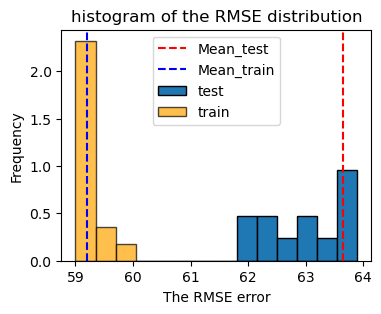

In [18]:
bin_params = {
    1: (3.5, 4.5, 0.06),
    2: (8.0, 9.0, 0.06),
    3: (12.0, 14.0, 0.15),
    4: (18.0, 21.0, 0.2),
    5: (59.0, 64.0, 0.35),
}


for bin_num in range(1, 6):

    print(f"RMSE per bin {bin_num}\n")
    rmse_bin_plot(test_RMSE[bin_num], train_RMSE[bin_num], *bin_params[bin_num])